In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

In [2]:
class Robot:
    def __init__(self, x=0.0, y=0.0, theta=0.0):
        self.x = x
        self.y = y
        self.theta = theta
        self.path = []
        
    def move(self, dx, dy, dtheta):
        self.x += dx
        self.y += dy
        self.theta += dtheta
        self.path.append((self.x, self.y))

In [5]:
class Lidar:
    def __init__(self, max_range=10.0, num_beams=360):
        self.max_range = max_range
        self.num_beams = num_beams
        
    def scan(self, environment, robot_pose):
        x, y, theta = robot_pose
        angles = np.linspace(0, 2*np.pi, self.num_beams, endpoint=False)
        ranges = []
        
        for angle in angles:
            beam_angle = angle + theta
            range_val = self.max_range
            
            for dist in np.linspace(0, self.max_range, 100):
                bx = x + dist * np.cos(beam_angle)
                by = y + dist * np.sin(beam_angle)
                
                if environment.is_occupied(bx, by):
                    range_val = dist
                    break
                    
            ranges.append(range_val)
            
        return np.array(ranges), angles

In [8]:
class Environment:
    def __init__(self, width=20, height=20):
        self.width = width
        self.height = height
        self.obstacles = []
        
    def add_obstacle(self, x, y, radius):
        self.obstacles.append((x, y, radius))
        
    def is_occupied(self, x, y):
        for ox, oy, radius in self.obstacles:
            if (x - ox)**2 + (y - oy)**2 <= radius**2:
                return True
        return False

In [11]:
def icp_algorithm(source_points, target_points, max_iterations=20, tolerance=0.001):
    transformation = np.eye(3)
    
    for _ in range(max_iterations):
        
        kdtree = KDTree(target_points)
        distances, indices = kdtree.query(source_points)
        
        matched_target = target_points[indices]
        
        H = np.dot((source_points - np.mean(source_points, axis=0)).T, 
                  (matched_target - np.mean(matched_target, axis=0)))
        
        U, S, Vt = np.linalg.svd(H)
        R = np.dot(Vt.T, U.T)
        t = np.mean(matched_target, axis=0) - np.dot(R, np.mean(source_points, axis=0))
        
        current_transformation = np.eye(3)
        current_transformation[:2, :2] = R
        current_transformation[:2, 2] = t
        transformation = np.dot(current_transformation, transformation)
        
        homogeneous = np.column_stack((source_points, np.ones(len(source_points))))
        source_points = np.dot(homogeneous, transformation.T)[:, :2]
        
        if np.mean(distances) < tolerance:
            break
            
    return transformation

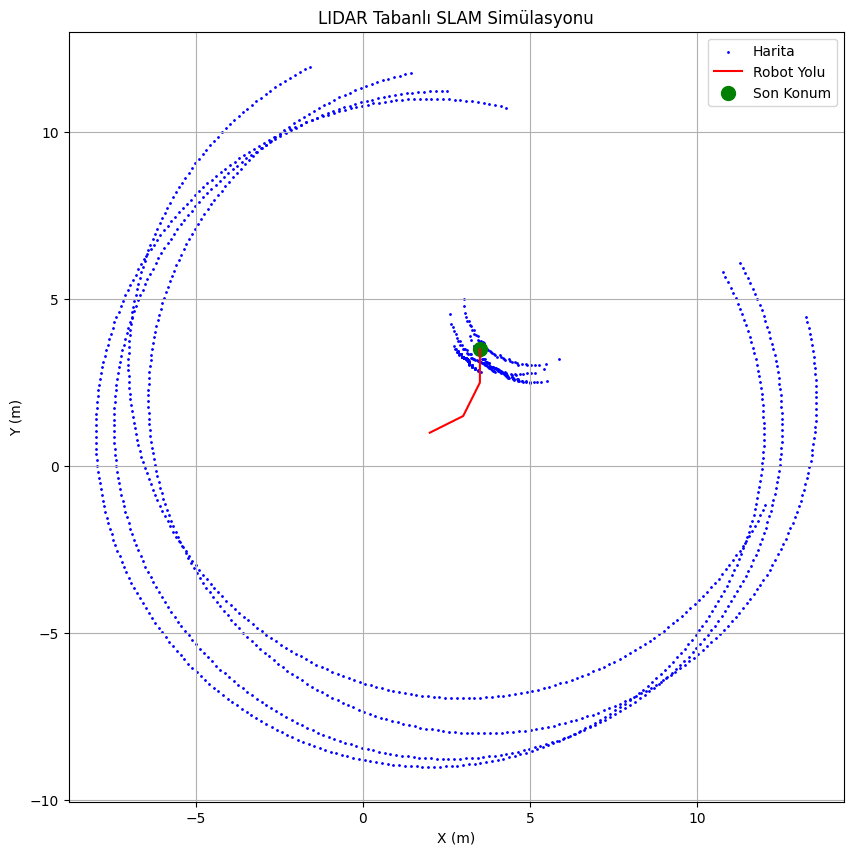

In [14]:
def run_slam_simulation():
    # Ortamı oluştur
    env = Environment()
    env.add_obstacle(5, 5, 2)
    env.add_obstacle(10, 10, 3)
    env.add_obstacle(15, 5, 1)
    
    # Robot ve LIDAR'ı başlat
    robot = Robot(1, 1, 0)
    lidar = Lidar()
    
    # Haritayı depolamak için
    global_map = []
    
    movements = [(1, 0, 0.1), (1, 0.5, 0), (0.5, 1, -0.1), (0, 1, 0)]
    
    for dx, dy, dtheta in movements:
        robot.move(dx, dy, dtheta)
        
        # LIDAR taraması
        ranges, angles = lidar.scan(env, (robot.x, robot.y, robot.theta))
        
        points = np.column_stack((
            ranges * np.cos(angles + robot.theta) + robot.x,
            ranges * np.sin(angles + robot.theta) + robot.y
        ))
        
        if len(global_map) > 10:
            transformation = icp_algorithm(points, np.array(global_map))
            homogeneous = np.column_stack((points, np.ones(len(points))))
            aligned_points = np.dot(homogeneous, transformation.T)[:, :2]
            points = aligned_points
            
        global_map.extend(points)
    
    plt.figure(figsize=(10, 10))
    if global_map:
        global_map = np.array(global_map)
        plt.scatter(global_map[:, 0], global_map[:, 1], s=1, c='blue', label='Harita')
    plt.plot([p[0] for p in robot.path], [p[1] for p in robot.path], 'r-', label='Robot Yolu')
    plt.scatter(robot.x, robot.y, c='green', s=100, label='Son Konum')
    plt.legend()
    plt.title('LIDAR Tabanlı SLAM Simülasyonu')
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.grid()
    plt.axis('equal')
    plt.show()

if __name__ == "__main__":
    run_slam_simulation()

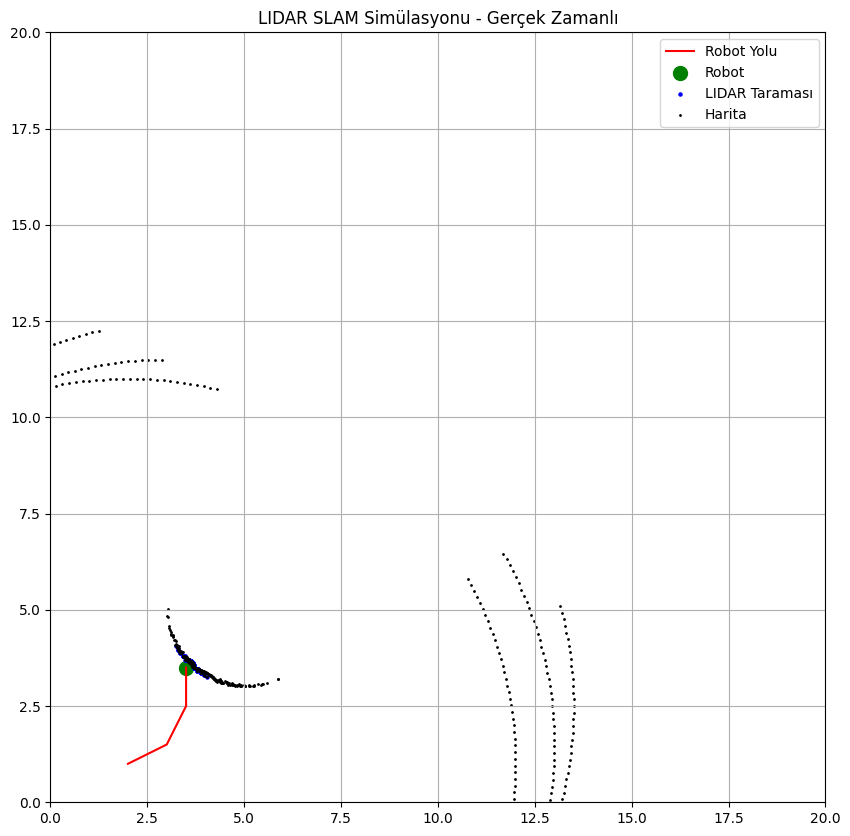

In [17]:
import matplotlib.animation as animation
from IPython.display import HTML

def create_slam_animation():
    # Ortamı ve robotu başlat
    env = Environment()
    env.add_obstacle(5, 5, 2)
    env.add_obstacle(10, 10, 3)
    env.add_obstacle(15, 5, 1)
    
    robot = Robot(1, 1, 0)
    lidar = Lidar()
    
    # Hareket komutları
    movements = [(1, 0, 0.1), (1, 0.5, 0), (0.5, 1, -0.1), (0, 1, 0)]
    
    # Görselleştirme için hazırlık
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 20)
    ax.set_title('LIDAR SLAM Simülasyonu - Gerçek Zamanlı')
    ax.grid(True)
    
    # Başlangıç elemanları
    robot_path_line, = ax.plot([], [], 'r-', label='Robot Yolu')
    robot_position = ax.scatter([], [], c='green', s=100, label='Robot')
    scan_points = ax.scatter([], [], c='blue', s=5, label='LIDAR Taraması')
    map_points = ax.scatter([], [], c='black', s=1, label='Harita')
    ax.legend()
    
    # Animasyon için veri depolama
    global_map = []
    frames_data = []
    
    for dx, dy, dtheta in movements:
        # Robotu hareket ettir
        robot.move(dx, dy, dtheta)
        
        # LIDAR taraması yap
        ranges, angles = lidar.scan(env, (robot.x, robot.y, robot.theta))
        
        # Tarama sonuçlarını Kartezyen koordinatlara çevir
        points = np.column_stack((
            ranges * np.cos(angles + robot.theta) + robot.x,
            ranges * np.sin(angles + robot.theta) + robot.y
        ))
        
        # ICP ile hizalama (basit tutmak için bu animasyonda atlıyoruz)
        # Gerçek uygulamada bu adımı eklemelisiniz
        
        # Haritayı güncelle
        global_map.extend(points)
        frames_data.append({
            'robot_pos': (robot.x, robot.y),
            'path': robot.path.copy(),
            'scan': points.copy(),
            'map': np.array(global_map).copy()
        })
    
    # Animasyon fonksiyonu
    def update(frame):
        data = frames_data[frame]
        
        # Robot konumunu ve yolunu güncelle
        robot_path_line.set_data([p[0] for p in data['path']], [p[1] for p in data['path']])
        robot_position.set_offsets([data['robot_pos'][0], data['robot_pos'][1]])
        
        # Tarama noktalarını güncelle
        scan_points.set_offsets(data['scan'])
        
        # Haritayı güncelle
        if len(data['map']) > 0:
            map_points.set_offsets(data['map'])
        
        return robot_path_line, robot_position, scan_points, map_points
    
    # Animasyonu oluştur
    ani = animation.FuncAnimation(
        fig, update, frames=len(frames_data),
        interval=500, blit=True, repeat_delay=2000
    )
    
    # GIF olarak kaydet
    ani.save('slam_simulation.gif', writer='pillow', fps=2, dpi=100)
    
    # Jupyter'de göstermek için
    return HTML(ani.to_jshtml())

# Animasyonu oluştur ve göster
create_slam_animation()